In [1]:
#!/usr/bin/env python3
"""
Visualization script for k-tuple demonstration results.
Compares best, worst, and random demonstrations with no-demonstration baseline.
Loads both 2-shot and 4-shot results.
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Set the style for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')

# Configure matplotlib for better aesthetics
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18

# Load the results for both 2-shot and 4-shot
persona_id = "cdf7cefb-7341-41d7-a193-ff0f2f962cf9"

# 2-shot results
results_file_2shot = f"icl_diy_pair_test_results/icl_pair_test_results_{persona_id}.npz"
print(f"Loading 2-shot results from: {results_file_2shot}")
data_2shot = np.load(results_file_2shot, allow_pickle=True)

# 4-shot results
results_file_4shot = f"icl_ktuple_test_results/icl_ktuple_test_results_k4_{persona_id}.npz"
print(f"Loading 4-shot results from: {results_file_4shot}")
data_4shot = np.load(results_file_4shot, allow_pickle=True)

# Function to process data
def process_data(data, k_shot):
    """Process data from npz file and return statistics."""
    tuple_categories = data['tuple_categories'] if 'tuple_categories' in data else data['pair_categories']
    log_probs_with_context = data['log_probs_with_context']
    log_probs_no_context = data['log_probs_no_context']
    accuracy_with_context = data['accuracy_with_context']
    accuracy_no_context = data['accuracy_no_context']
    accuracy_gain = data['accuracy_gain']
    
    # Compute probabilities from log probabilities
    probs_with_context = np.exp(log_probs_with_context)
    probs_no_context = np.exp(log_probs_no_context)
    
    # Compute statistics for each category
    categories = ['best', 'worst', 'random']
    category_stats = {}
    
    for category in categories:
        category_mask = np.array([cat == category for cat in tuple_categories])
        category_indices = np.where(category_mask)[0]
        
        category_stats[category] = {
            'mean_prob': probs_with_context[category_indices, :].mean() * 100,
            'std_prob': probs_with_context[category_indices, :].std() * 100,
            'mean_accuracy': accuracy_with_context[category_indices, :].mean() * 100,
            'std_accuracy': accuracy_with_context[category_indices, :].std() * 100,
            'mean_acc_gain': accuracy_gain[category_indices, :].mean() * 100,
            'std_acc_gain': accuracy_gain[category_indices, :].std() * 100,
        }
    
    # Add no-context baseline statistics
    category_stats['no_demo'] = {
        'mean_prob': probs_no_context.mean() * 100,
        'std_prob': probs_no_context.std() * 100,
        'mean_accuracy': accuracy_no_context.mean() * 100,
        'std_accuracy': accuracy_no_context.std() * 100,
        'mean_acc_gain': 0.0,
        'std_acc_gain': 0.0,
    }
    
    return category_stats, tuple_categories, probs_with_context, probs_no_context, accuracy_with_context, accuracy_no_context

# Process both datasets
print("\n" + "="*80)
print("Processing 2-shot data...")
stats_2shot, categories_2shot, probs_2shot, probs_no_2shot, acc_2shot, acc_no_2shot = process_data(data_2shot, 2)

print("\nProcessing 4-shot data...")
stats_4shot, categories_4shot, probs_4shot, probs_no_4shot, acc_4shot, acc_no_4shot = process_data(data_4shot, 4)

# Print statistics
print("\n" + "="*80)
print("2-SHOT Statistics")
print("="*80)
for category in ['no_demo', 'best', 'worst', 'random']:
    stats = stats_2shot[category]
    print(f"\n{category.upper()}:")
    print(f"  Mean probability: {stats['mean_prob']:.2f}% ± {stats['std_prob']:.2f}%")
    print(f"  Mean accuracy:    {stats['mean_accuracy']:.2f}% ± {stats['std_accuracy']:.2f}%")
    print(f"  Mean acc gain:    {stats['mean_acc_gain']:.2f}% ± {stats['std_acc_gain']:.2f}%")

print("\n" + "="*80)
print("4-SHOT Statistics")
print("="*80)
for category in ['no_demo', 'best', 'worst', 'random']:
    stats = stats_4shot[category]
    print(f"\n{category.upper()}:")
    print(f"  Mean probability: {stats['mean_prob']:.2f}% ± {stats['std_prob']:.2f}%")
    print(f"  Mean accuracy:    {stats['mean_accuracy']:.2f}% ± {stats['std_accuracy']:.2f}%")
    print(f"  Mean acc gain:    {stats['mean_acc_gain']:.2f}% ± {stats['std_acc_gain']:.2f}%")

Loading 2-shot results from: icl_diy_pair_test_results/icl_pair_test_results_cdf7cefb-7341-41d7-a193-ff0f2f962cf9.npz
Loading 4-shot results from: icl_ktuple_test_results/icl_ktuple_test_results_k4_cdf7cefb-7341-41d7-a193-ff0f2f962cf9.npz

Processing 2-shot data...

Processing 4-shot data...

2-SHOT Statistics

NO_DEMO:
  Mean probability: 56.60% ± 15.94%
  Mean accuracy:    67.97% ± 46.66%
  Mean acc gain:    0.00% ± 0.00%

BEST:
  Mean probability: 59.95% ± 20.80%
  Mean accuracy:    69.69% ± 45.96%
  Mean acc gain:    1.72% ± 41.52%

WORST:
  Mean probability: 58.32% ± 18.55%
  Mean accuracy:    70.04% ± 45.81%
  Mean acc gain:    2.07% ± 42.11%

RANDOM:
  Mean probability: 59.69% ± 21.41%
  Mean accuracy:    69.02% ± 46.24%
  Mean acc gain:    1.05% ± 41.87%

4-SHOT Statistics

NO_DEMO:
  Mean probability: 56.60% ± 15.94%
  Mean accuracy:    67.97% ± 46.66%
  Mean acc gain:    0.00% ± 0.00%

BEST:
  Mean probability: 61.46% ± 24.42%
  Mean accuracy:    69.69% ± 45.96%
  Mean acc ga

In [12]:
# (np.exp(data_4shot['log_probs_with_context'])[:5]-1e-10>0.5).mean()
# (np.exp(data_4shot['log_probs_with_context'])[:5]>0.5).mean()


2-shot results saved to: boxplot_2shot_cdf7cefb.png


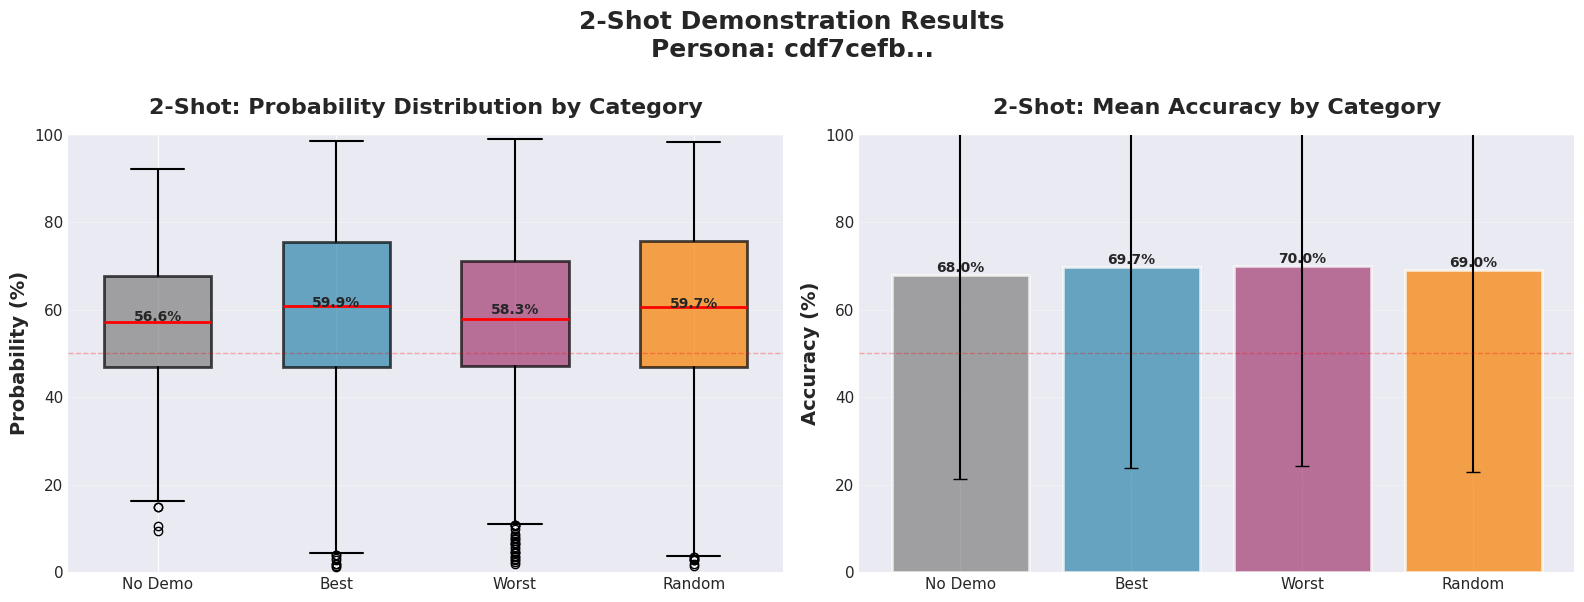

4-shot results saved to: boxplot_4shot_cdf7cefb.png


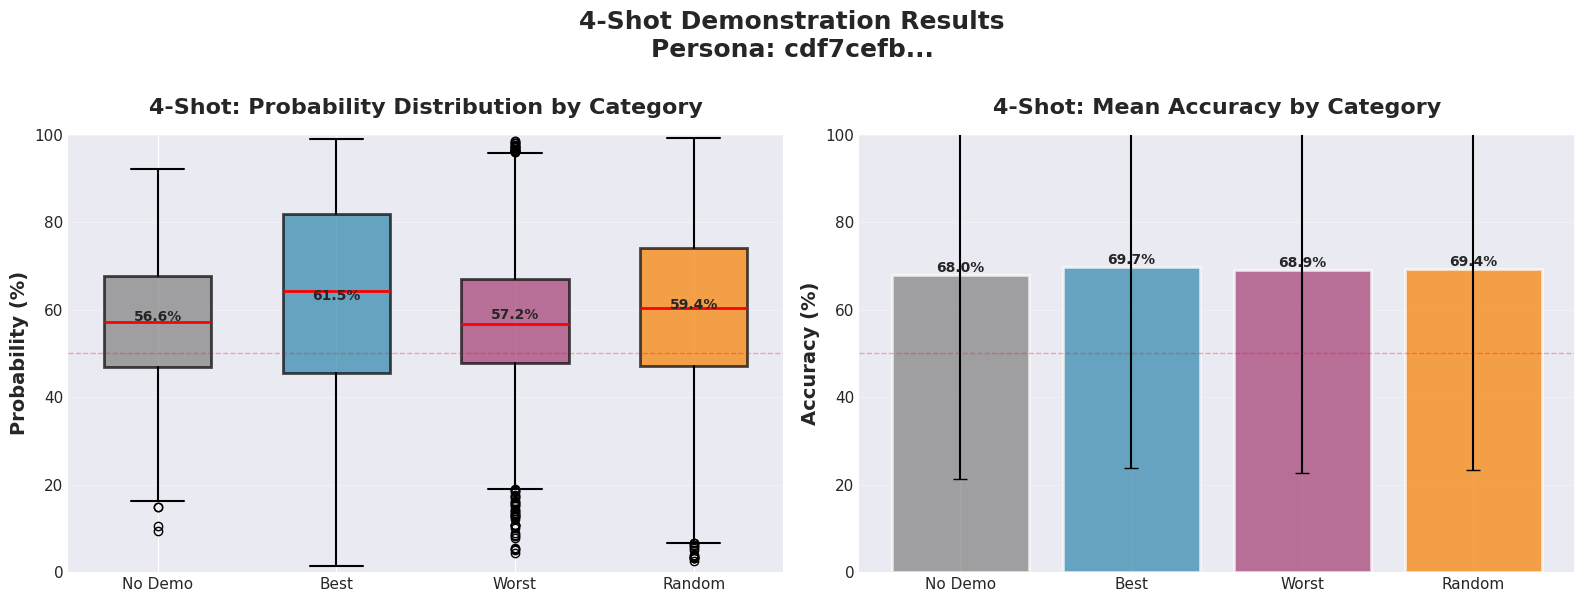


Visualization complete!


In [23]:
# Create visualization for 2-shot results
# Boxplot for probability (continuous), bar chart for accuracy (binary)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define colors for each category
colors = {
    'no_demo': '#808080',  # Gray
    'best': '#2E86AB',     # Blue
    'worst': '#A23B72',    # Purple
    'random': '#F77F00'    # Orange
}

category_labels = {
    'no_demo': 'No Demo',
    'best': 'Best',
    'worst': 'Worst',
    'random': 'Random'
}

categories_plot = ['no_demo', 'best', 'worst', 'random']

# Prepare data for boxplots - 2-shot
prob_data_2shot = []

# No demo data
prob_data_2shot.append(probs_no_2shot.flatten() * 100)

# Best, worst, random
for category in ['best', 'worst', 'random']:
    category_mask = np.array([cat == category for cat in categories_2shot])
    category_indices = np.where(category_mask)[0]
    
    prob_data_2shot.append(probs_2shot[category_indices, :].flatten() * 100)

# Plot probability boxplot - 2-shot
ax = axes[0]
bp = ax.boxplot(prob_data_2shot, labels=[category_labels[cat] for cat in categories_plot],
                patch_artist=True, widths=0.6,
                boxprops=dict(linewidth=2),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

for patch, category in zip(bp['boxes'], categories_plot):
    patch.set_facecolor(colors[category])
    patch.set_alpha(0.7)

ax.set_ylabel('Probability (%)', fontweight='bold', fontsize=14)
ax.set_title('2-Shot: Probability Distribution by Category', fontweight='bold', fontsize=16, pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')

# Add mean probability labels on boxplot
for i, category in enumerate(categories_plot):
    mean_prob = stats_2shot[category]['mean_prob']
    ax.text(i + 1, mean_prob, f'{mean_prob:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot accuracy bar chart - 2-shot
ax = axes[1]
x_pos = np.arange(len(categories_plot))
means = [stats_2shot[cat]['mean_accuracy'] for cat in categories_plot]
stds = [stats_2shot[cat]['std_accuracy'] for cat in categories_plot]

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='white', linewidth=2)

for bar, category in zip(bars, categories_plot):
    bar.set_facecolor(colors[category])

ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=14)
ax.set_title('2-Shot: Mean Accuracy by Category', fontweight='bold', fontsize=16, pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels([category_labels[cat] for cat in categories_plot])
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

fig.suptitle(f'2-Shot Demonstration Results\nPersona: {persona_id[:8]}...',
             fontweight='bold', fontsize=18, y=1.00)

plt.tight_layout()

# Save the figure
output_path = f'boxplot_2shot_{persona_id[:8]}.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n2-shot results saved to: {output_path}")

plt.show()

# Create visualization for 4-shot results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for boxplots - 4-shot
prob_data_4shot = []

# No demo data
prob_data_4shot.append(probs_no_4shot.flatten() * 100)

# Best, worst, random
for category in ['best', 'worst', 'random']:
    category_mask = np.array([cat == category for cat in categories_4shot])
    category_indices = np.where(category_mask)[0]
    
    prob_data_4shot.append(probs_4shot[category_indices, :].flatten() * 100)

# Plot probability boxplot - 4-shot
ax = axes[0]
bp = ax.boxplot(prob_data_4shot, labels=[category_labels[cat] for cat in categories_plot],
                patch_artist=True, widths=0.6,
                boxprops=dict(linewidth=2),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

for patch, category in zip(bp['boxes'], categories_plot):
    patch.set_facecolor(colors[category])
    patch.set_alpha(0.7)

ax.set_ylabel('Probability (%)', fontweight='bold', fontsize=14)
ax.set_title('4-Shot: Probability Distribution by Category', fontweight='bold', fontsize=16, pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')

# Add mean probability labels on boxplot
for i, category in enumerate(categories_plot):
    mean_prob = stats_4shot[category]['mean_prob']
    ax.text(i + 1, mean_prob, f'{mean_prob:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot accuracy bar chart - 4-shot
ax = axes[1]
means = [stats_4shot[cat]['mean_accuracy'] for cat in categories_plot]
stds = [stats_4shot[cat]['std_accuracy'] for cat in categories_plot]

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='white', linewidth=2)

for bar, category in zip(bars, categories_plot):
    bar.set_facecolor(colors[category])

ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=14)
ax.set_title('4-Shot: Mean Accuracy by Category', fontweight='bold', fontsize=16, pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels([category_labels[cat] for cat in categories_plot])
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

fig.suptitle(f'4-Shot Demonstration Results\nPersona: {persona_id[:8]}...',
             fontweight='bold', fontsize=18, y=1.00)

plt.tight_layout()

# Save the figure
output_path = f'boxplot_4shot_{persona_id[:8]}.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"4-shot results saved to: {output_path}")

plt.show()

print("\n" + "="*80)
print("Visualization complete!")
print("="*80)


Trends figure saved to: trends_2shot_to_4shot_cdf7cefb.png


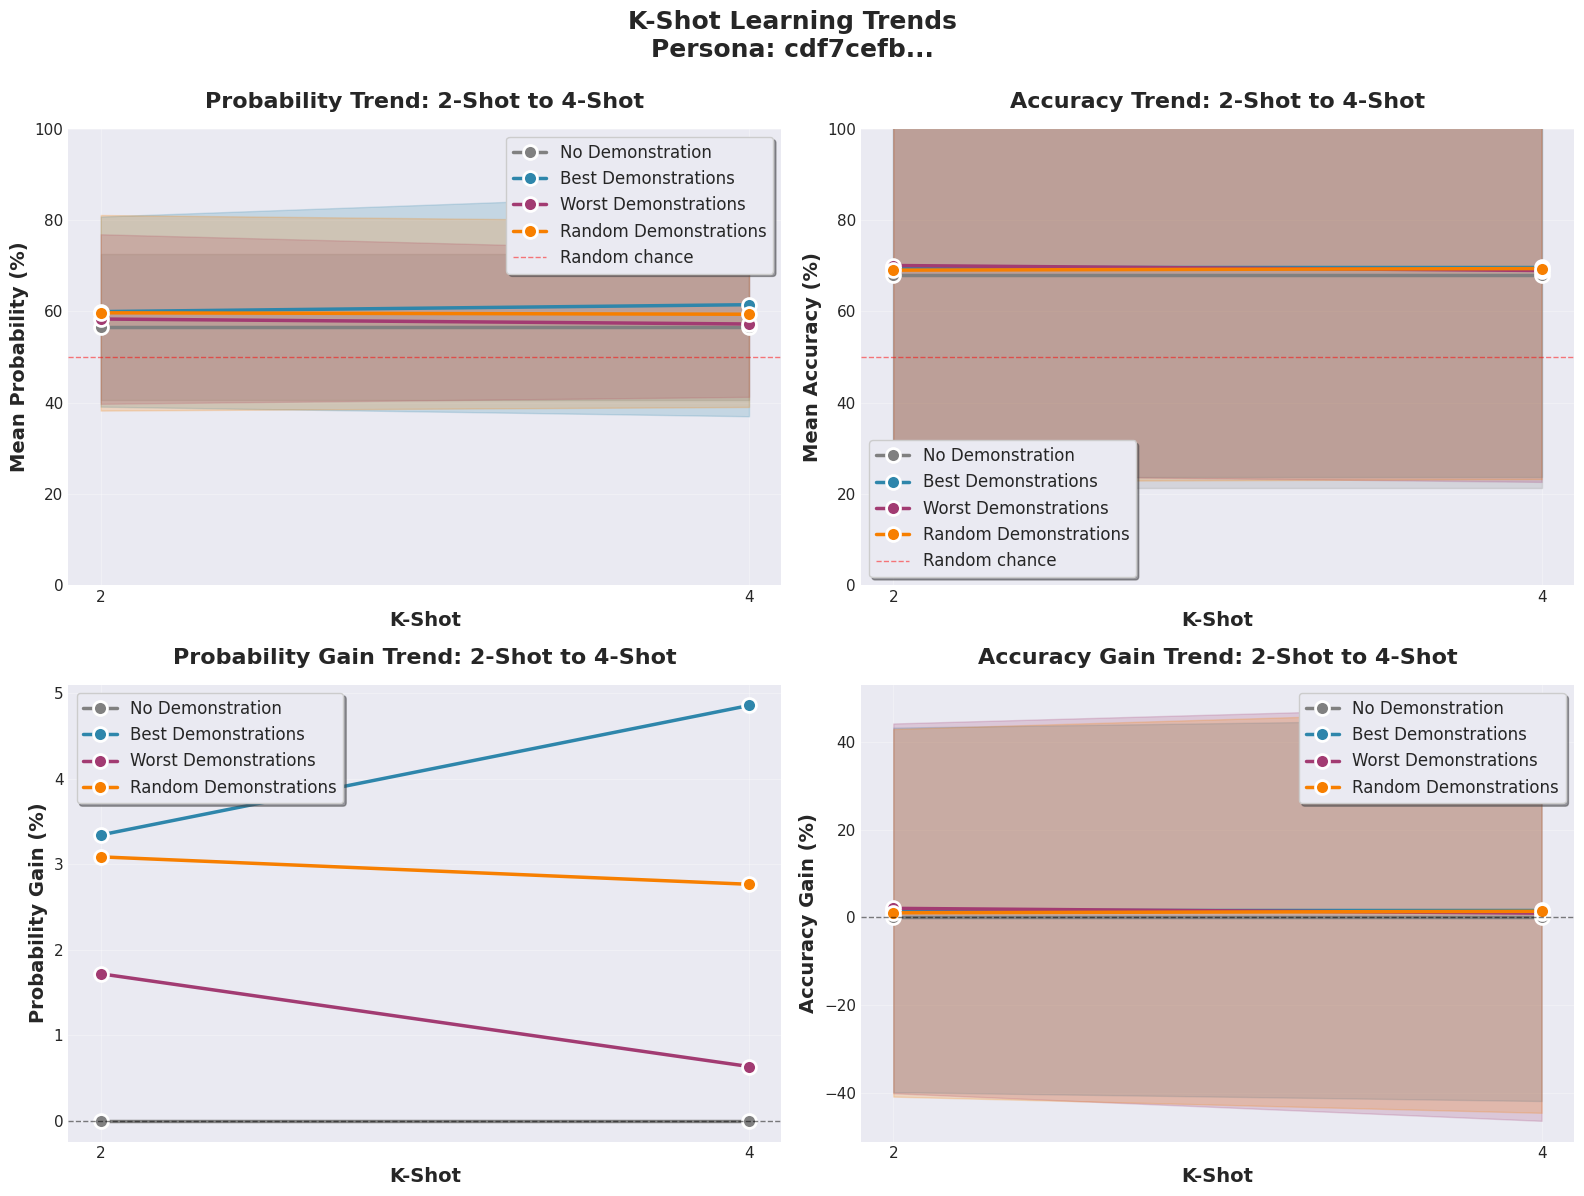

In [24]:
# Line plot showing trends from 2-shot to 4-shot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define colors for each category
colors = {
    'no_demo': '#808080',  # Gray
    'best': '#2E86AB',     # Blue
    'worst': '#A23B72',    # Purple
    'random': '#F77F00'    # Orange
}

category_labels = {
    'no_demo': 'No Demonstration',
    'best': 'Best Demonstrations',
    'worst': 'Worst Demonstrations',
    'random': 'Random Demonstrations'
}

categories_plot = ['no_demo', 'best', 'worst', 'random']
k_shots = [2, 4]

# Plot 1: Probability trend
ax = axes[0, 0]
for category in categories_plot:
    means = [stats_2shot[category]['mean_prob'], stats_4shot[category]['mean_prob']]
    stds = [stats_2shot[category]['std_prob'], stats_4shot[category]['std_prob']]
    
    ax.plot(k_shots, means, marker='o', linewidth=2.5, markersize=10,
            color=colors[category], label=category_labels[category],
            markeredgewidth=2, markeredgecolor='white')
    ax.fill_between(k_shots, 
                    [m - s for m, s in zip(means, stds)], 
                    [m + s for m, s in zip(means, stds)],
                    alpha=0.2, color=colors[category])

ax.set_xlabel('K-Shot', fontweight='bold')
ax.set_ylabel('Mean Probability (%)', fontweight='bold')
ax.set_title('Probability Trend: 2-Shot to 4-Shot', fontweight='bold', pad=15)
ax.set_xticks(k_shots)
ax.grid(True, alpha=0.3)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random chance')
ax.legend(loc='best', frameon=True, shadow=True)
ax.set_ylim(0, 100)

# Plot 2: Accuracy trend
ax = axes[0, 1]
for category in categories_plot:
    means = [stats_2shot[category]['mean_accuracy'], stats_4shot[category]['mean_accuracy']]
    stds = [stats_2shot[category]['std_accuracy'], stats_4shot[category]['std_accuracy']]
    
    ax.plot(k_shots, means, marker='o', linewidth=2.5, markersize=10,
            color=colors[category], label=category_labels[category],
            markeredgewidth=2, markeredgecolor='white')
    ax.fill_between(k_shots, 
                    [m - s for m, s in zip(means, stds)], 
                    [m + s for m, s in zip(means, stds)],
                    alpha=0.2, color=colors[category])

ax.set_xlabel('K-Shot', fontweight='bold')
ax.set_ylabel('Mean Accuracy (%)', fontweight='bold')
ax.set_title('Accuracy Trend: 2-Shot to 4-Shot', fontweight='bold', pad=15)
ax.set_xticks(k_shots)
ax.grid(True, alpha=0.3)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random chance')
ax.legend(loc='best', frameon=True, shadow=True)
ax.set_ylim(0, 100)

# Plot 3: Probability Gain trend
ax = axes[1, 0]
baseline_prob_2shot = stats_2shot['no_demo']['mean_prob']
baseline_prob_4shot = stats_4shot['no_demo']['mean_prob']

for category in categories_plot:
    gain_2shot = stats_2shot[category]['mean_prob'] - baseline_prob_2shot
    gain_4shot = stats_4shot[category]['mean_prob'] - baseline_prob_4shot
    means = [gain_2shot, gain_4shot]
    
    ax.plot(k_shots, means, marker='o', linewidth=2.5, markersize=10,
            color=colors[category], label=category_labels[category],
            markeredgewidth=2, markeredgecolor='white')

ax.set_xlabel('K-Shot', fontweight='bold')
ax.set_ylabel('Probability Gain (%)', fontweight='bold')
ax.set_title('Probability Gain Trend: 2-Shot to 4-Shot', fontweight='bold', pad=15)
ax.set_xticks(k_shots)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.legend(loc='best', frameon=True, shadow=True)

# Plot 4: Accuracy Gain trend
ax = axes[1, 1]
for category in categories_plot:
    means = [stats_2shot[category]['mean_acc_gain'], stats_4shot[category]['mean_acc_gain']]
    stds = [stats_2shot[category]['std_acc_gain'], stats_4shot[category]['std_acc_gain']]
    
    ax.plot(k_shots, means, marker='o', linewidth=2.5, markersize=10,
            color=colors[category], label=category_labels[category],
            markeredgewidth=2, markeredgecolor='white')
    ax.fill_between(k_shots, 
                    [m - s for m, s in zip(means, stds)], 
                    [m + s for m, s in zip(means, stds)],
                    alpha=0.2, color=colors[category])

ax.set_xlabel('K-Shot', fontweight='bold')
ax.set_ylabel('Accuracy Gain (%)', fontweight='bold')
ax.set_title('Accuracy Gain Trend: 2-Shot to 4-Shot', fontweight='bold', pad=15)
ax.set_xticks(k_shots)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.legend(loc='best', frameon=True, shadow=True)

fig.suptitle(f'K-Shot Learning Trends\nPersona: {persona_id[:8]}...',
             fontweight='bold', fontsize=18, y=0.995)

plt.tight_layout()

# Save the figure
output_path = f'trends_2shot_to_4shot_{persona_id[:8]}.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nTrends figure saved to: {output_path}")

plt.show()